In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import igraph as ig
import matplotlib.pyplot as plt
from shapely.geometry import MultiLineString

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Centralities

In [25]:
gdf = gpd.read_file('../data/processed/Centralidades_AMG_2020-2040_UTM_v1.geojson', driver='GeoJSON')
print(gdf.shape)
gdf.head(1)

(27, 40)


,fid,nombre,clasif,can_rut_tp,cap_rut_tp,dens_pob,pers_ocupa,equipamien,l_tp_masiv,uni_econ,...,auxiliar16,auxiliar17,auxiliar18,auxiliar19,auxiliar20,numero,n_centrali,RmvCnt,Tiempo,geometry
0,11.0,Centro Tlaquepaque,Centralidad Metropolitana,0.69,0.32,1.0,0.48,0.94,0.5,0.58,...,None,None,1.0,675392.648633,2.283998e+06,3.0,Centro &Tlaquepaque,2,2040,POINT (675994.778 2283149.503)


<AxesSubplot:>

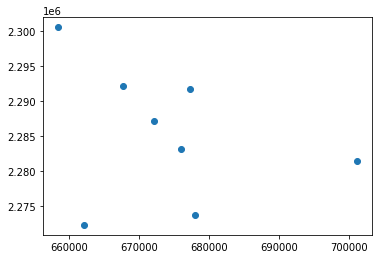

In [26]:
gdf_cnt = gdf[gdf['numero'].isin([1,2,3,6,21,23,24,25])]
gdf_cnt.plot()

## Hex-bins

In [27]:
amg = {"Guadalajara":{"mpos":["14002", "14039", "14044", "14051", "14070", "14097", "14098", "14101", "14120", "14124"],"edo":["14"]}}
df_amg = pd.DataFrame(amg)
df_amg.head(1)

,Guadalajara
edo,[14]


In [28]:
hex_gdf = gpd.GeoDataFrame()

for m in df_amg.loc['mpos'][0]:
    query = f"SELECT * FROM hexgrid.hexgrid_mx WHERE \"CVEGEO\" LIKE \'{m}\'"
    hex_gdf = hex_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
print(hex_gdf.shape)
hex_gdf.head(1)

(4095, 3)


,geometry,hex_id_8,CVEGEO
0,"POLYGON ((-103.60989 20.39686, -103.61044 20.4...",8849abc91bfffff,14002


<AxesSubplot:>

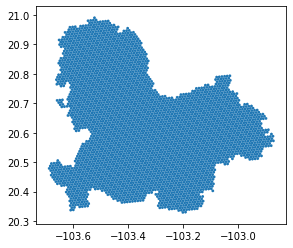

In [29]:
hex_gdf.plot()

## OSMnx

In [30]:
G,nodes,edges = aup.graph_from_hippo(hex_gdf, 'osmnx')

In [31]:
print(nodes.shape)
nodes.head(1)

(174036, 4)


,x,y,street_count,geometry
osmid,,,,
28751344,-103.306309,20.711533,3,POINT (-103.30631 20.71153)


<AxesSubplot:>

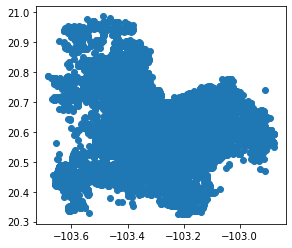

In [32]:
nodes.plot()

In [33]:
print(edges.shape)
edges.head(1)

(419306, 3)


,,,osmid,length,geometry
u,v,key,,,
1754406771,1754406780,0,163760869,157.211,"LINESTRING (-103.40211 20.50038, -103.40063 20..."


<AxesSubplot:>

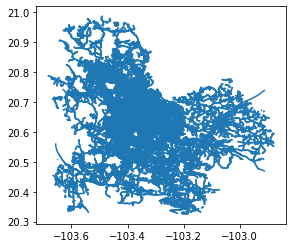

In [34]:
edges.plot()

## Hex to nodes

In [13]:
hex_gdf = hex_gdf.to_crs("EPSG:32613")
hex_cnt = hex_gdf.centroid
hex_cnt = gpd.GeoDataFrame(hex_cnt, geometry=0)
hex_cnt = hex_cnt.to_crs("EPSG:4326")
print(hex_cnt.shape)
hex_cnt.head(1)

(4095, 1)


,0
0,POINT (-103.61497 20.39899)


<AxesSubplot:>

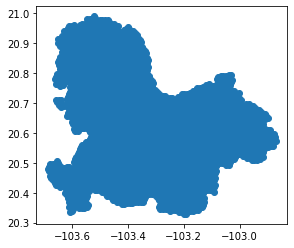

In [14]:
hex_cnt.plot()

In [15]:
hex_nodes = aup.find_nearest(G, nodes, hex_cnt, return_distance=True)
print(hex_nodes.shape)
hex_nodes.head(1)

(4095, 3)


,0,osmid,distance_node
0,POINT (-103.61497 20.39899),6777785195,638.068276


<AxesSubplot:>

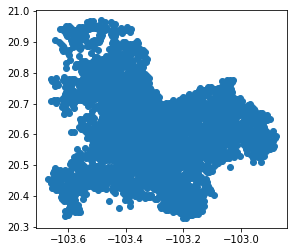

In [16]:
hex_nodes.loc[hex_nodes.distance_node<500].plot()

## Centrality to nodes

In [73]:
gdf_cnt = gdf_cnt.to_crs("EPSG:4326")
centrality_nodes = aup.find_nearest(G, nodes, gdf_cnt, return_distance=True)
print(centrality_nodes.shape)
centrality_nodes.head(1)

(8, 42)


,fid,nombre,clasif,can_rut_tp,cap_rut_tp,dens_pob,pers_ocupa,equipamien,l_tp_masiv,uni_econ,...,auxiliar18,auxiliar19,auxiliar20,numero,n_centrali,RmvCnt,Tiempo,geometry,osmid,distance_node
0,11.0,Centro Tlaquepaque,Centralidad Metropolitana,0.69,0.32,1.0,0.48,0.94,0.5,0.58,...,1.0,675392.648633,2.283998e+06,3.0,Centro &Tlaquepaque,2,2040,POINT (-103.31079 20.63935),2970845383,23.144712


## Nearest distance

In [74]:
orig = list(hex_nodes.loc[hex_nodes.distance_node<500, 'osmid'])
dest = list(centrality_nodes.osmid)

In [319]:
#nodes_G, edges_G = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

In [75]:
nodes_c = nodes.copy()
edges_c = edges.copy()
gdf_f = centrality_nodes.copy()
g, weights, node_mapping = aup.to_igraph(nodes_c,edges_c) #convert to igraph to run the calculations
seeds_dest = aup.get_seeds(gdf_f, node_mapping, 'osmid')
seeds_org = aup.get_seeds(hex_nodes.loc[hex_nodes.distance_node<500], node_mapping, 'osmid')
keys_list = list(node_mapping)
#voronoi_assignment = voronoi_cpu(g, weights, seeds)
#distances = get_distances(g,seeds,weights,voronoi_assignment)

In [76]:
shortest_path_len = g.shortest_paths_dijkstra(seeds_org, seeds_dest, weights=weights)
nearest_seed = np.array(shortest_path_len).argmin(axis=1)

In [77]:
shortest_path_nodes = [ig.Graph.get_shortest_paths(g, seeds_org[i], seeds_dest[nearest_seed[i]], weights=weights) for i in range(len(seeds_org))]

<ipython-input-77-9b6fb63b5e2e>:1: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:441
  shortest_path_nodes = [ig.Graph.get_shortest_paths(g, seeds_org[i], seeds_dest[nearest_seed[i]], weights=weights) for i in range(len(seeds_org))]


In [78]:
routes_osmid = [[keys_list[shortest_path_nodes[x][0][i]] for i in range(len(shortest_path_nodes[x][0]))] for x in range(len(shortest_path_nodes))]
len(routes_osmid)

2945

In [79]:
lines = []
edges_G = ox.graph_to_gdfs(G, nodes=False).reset_index().set_index(['u', 'v']).sort_index()

In [80]:
for r in range(len(routes_osmid)):
    route_pairwise = zip(routes_osmid[r][:-1], routes_osmid[r][1:])
    
    for z in route_pairwise:
        try:
            osmid_touple = (z[0],z[1])
            lines.append(edges_G.loc[osmid_touple, ['osmid','geometry']].iloc[0])
        except:
            osmid_touple = (z[1],z[0])
            lines.append(edges_G.loc[osmid_touple, ['osmid','geometry']].iloc[0])
            
    print('route',r,'finished')
        

route 0 finished
route 1 finished
route 2 finished
route 3 finished
route 4 finished
route 5 finished
route 6 finished
route 7 finished
route 8 finished
route 9 finished
route 10 finished
route 11 finished
route 12 finished
route 13 finished
route 14 finished
route 15 finished
route 16 finished
route 17 finished
route 18 finished
route 19 finished
route 20 finished
route 21 finished
route 22 finished
route 23 finished
route 24 finished
route 25 finished
route 26 finished
route 27 finished
route 28 finished
route 29 finished
route 30 finished
route 31 finished
route 32 finished
route 33 finished
route 34 finished
route 35 finished
route 36 finished
route 37 finished
route 38 finished
route 39 finished
route 40 finished
route 41 finished
route 42 finished
route 43 finished
route 44 finished
route 45 finished
route 46 finished
route 47 finished
route 48 finished
route 49 finished
route 50 finished
route 51 finished
route 52 finished
route 53 finished
route 54 finished
route 55 finished
ro

In [81]:
route_gdf = gpd.GeoDataFrame(lines)
route_gdf.head(1)

,,osmid,geometry
8406970969,8406970966,905274775,"LINESTRING (-103.18201 20.57506, -103.18163 20..."


In [82]:
route_gdf = route_gdf.set_crs("EPSG:4326")
route_geom = route_gdf.geometry
## Extracts coordinates from polygon as DataFrame
coord_val = route_geom.bounds
## Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

<AxesSubplot:>

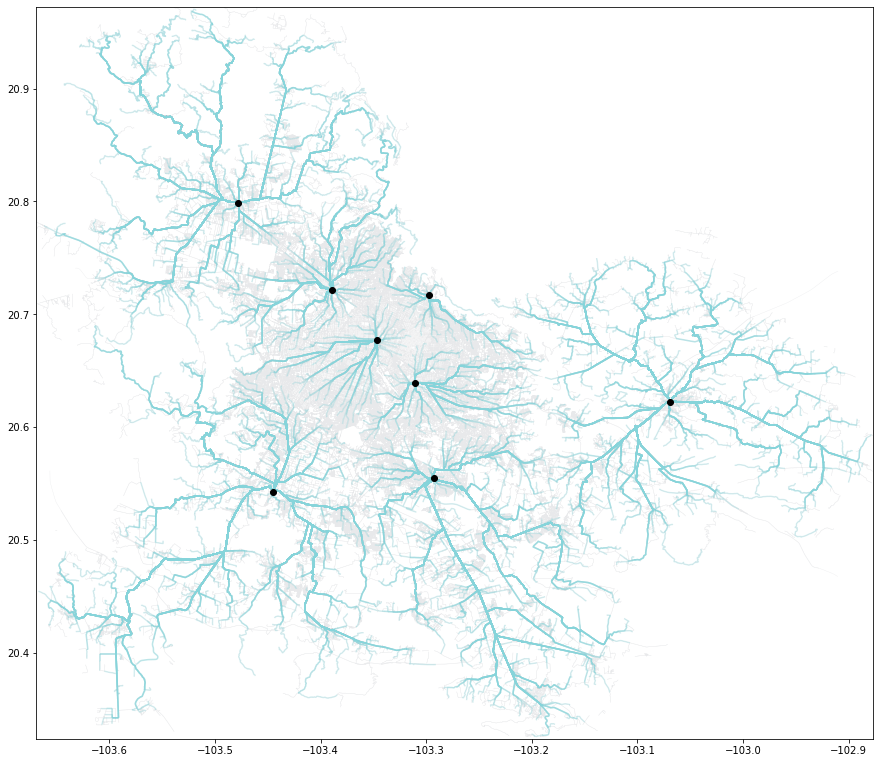

In [89]:
fig, ax = plt.subplots(figsize=(15,15))

xmin = w - 0.002
xmax = e + 0.002
ymin = s - 0.002
ymax = n + 0.002
#edges_plt = ox.graph_to_gdfs(G, nodes=False)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

gdf_cnt.plot(ax=ax, color='black', zorder=2)
edges.plot(ax=ax, color='#e8e9eb',linewidth=0.3, zorder=-1)
#edges_plt[(edges_plt['highway']=='primary') | (edges_plt['highway']=='secondary')].plot(ax=axes, color='#e8e9eb',linewidth=0.5, zorder=0)
route_gdf.plot(ax=ax, color='#86d4da', alpha=0.3, zorder=1)

In [86]:
routes_join = route_gdf.reset_index().groupby(['level_0','level_1']).count()
routes_join.head(5)

,,osmid,geometry
level_0,level_1,,
28774889,1912399399,2,2
28775949,1792564485,2,2
28776032,28776223,2,2
28776223,28776246,2,2
28776246,28775949,2,2


In [87]:
route_gdf.to_file('../data/processed/hex_route_centralities1.geojson', driver='GeoJSON')

## Grouping routes

In [9]:
gdf_routes_all = gpd.read_file('../data/processed/hex_route_centralities1.geojson', driver='GeoJSON')
print(gdf_routes_all.shape)
gdf_routes_all.head(2)

(297191, 4)


,level_0,level_1,osmid,geometry
0,8406970969,8406970966,905274775,"LINESTRING (-103.18201 20.57506, -103.18163 20..."
1,8406970966,1457051196,475933850,"LINESTRING (-103.18090 20.57538, -103.18047 20..."


In [13]:
gdf_diss = gdf_routes_all.groupby(['level_0','level_1']).count()
gdf_diss.reset_index(inplace=True)
gdf_diss.rename(columns={'osmid':'count'}, inplace=True)
gdf_diss.drop(columns=['geometry'], inplace=True)
print(gdf_diss.shape)
gdf_diss.head(5)

(32075, 3)


,level_0,level_1,count
0,28774889,1912399399,2
1,28775949,1792564485,2
2,28776032,28776223,2
3,28776223,28776246,2
4,28776246,28775949,2


In [22]:
gdf_routes_diss = gdf_routes_all.merge(gdf_diss, left_on=['level_0','level_1'],
                right_on=['level_0','level_1'], how='left')
gdf_routes_diss.drop_duplicates(inplace=True)
print(gdf_routes_diss.shape)
gdf_routes_diss.head(2)

(32075, 5)


,level_0,level_1,osmid,geometry,count
0,8406970969,8406970966,905274775,"LINESTRING (-103.18201 20.57506, -103.18163 20...",1
1,8406970966,1457051196,475933850,"LINESTRING (-103.18090 20.57538, -103.18047 20...",1


In [23]:
gdf_routes_diss['count'].sum()

297191

In [35]:
gdf_routes_diss = gdf_routes_diss.set_crs("EPSG:4326")
route_geom = gdf_routes_diss.geometry
## Extracts coordinates from polygon as DataFrame
coord_val = route_geom.bounds
## Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

<AxesSubplot:>

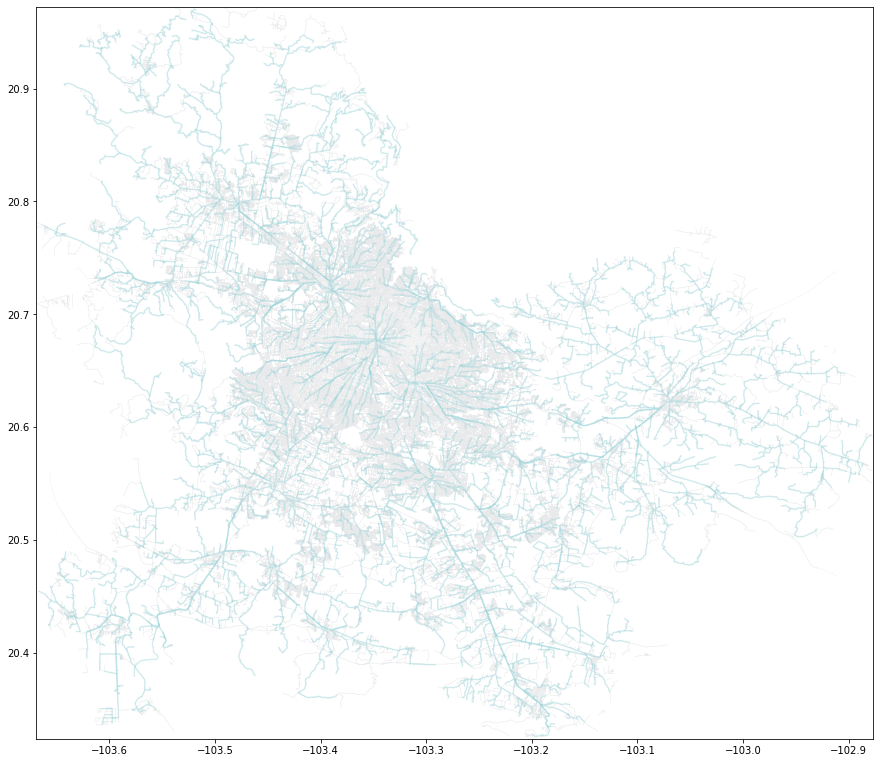

In [36]:
fig, ax = plt.subplots(figsize=(15,15))

xmin = w - 0.002
xmax = e + 0.002
ymin = s - 0.002
ymax = n + 0.002
#edges_plt = ox.graph_to_gdfs(G, nodes=False)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

gdf_cnt.plot(ax=ax, color='black', zorder=2)
edges.plot(ax=ax, color='#e8e9eb',linewidth=0.3, zorder=-1)
#edges_plt[(edges_plt['highway']=='primary') | (edges_plt['highway']=='secondary')].plot(ax=axes, color='#e8e9eb',linewidth=0.5, zorder=0)
gdf_routes_diss.plot(ax=ax, color='#86d4da', alpha=0.3, zorder=1)

In [37]:
gdf_routes_diss.to_file('../data/processed/hex_route_centralities1_dissolved.geojson', driver='GeoJSON')